In [1]:
import os
from os import path

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import spreg
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import colors
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
from scipy import stats

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
input_dir = "data/output/"
output_dir = "data/output/regressions"

# Input data

In [3]:
# get input data
env_data = gpd.read_file(path.join(input_dir,"AGGR_DHS_buffer_4stats.shp"))# get environmental data

dhs_data = pd.read_csv("data/temp/DHSdata_aggr2join_buffer.csv")# get DHS data
dhs_data = dhs_data.iloc[: , 1:]# drop first column (old index)
dhs_data = dhs_data.drop(['geometry'], axis=1)# drop geometry column

data_gdf = pd.merge(dhs_data, env_data, on='v001', how='left')# join datasets
data_gdf = gpd.GeoDataFrame(data_gdf,geometry='geometry')# turn into GDF
data_gdf['geometry'] = data_gdf['geometry'].centroid# turn back to point geometry

data_gdf

,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,0.935515,0.01155938331595235,0,0,22.22222222222224,22.22222222222222,0,0,0,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,0.000000,0,0,0,100,100,0,0,0,POINT (-8.21198 6.46250)
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,0.414876,0.009099259461077081,None,None,None,None,None,None,None,POINT (-8.32456 7.27460)
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,0.000000,0,0,0,100,100,0,0,0,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,0.150578,0.004093965954248088,0,0,21.4285714285714,21.42857142857141,0,0,0,POINT (-5.71578 6.36162)
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,2.964994,0.05858511109025522,0,0,0,0,0,0,0,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,6.170473,0.1045737020213004,0,0,12.50000000000005,12.50000000000004,0,0,0,POINT (-6.51277 6.65822)


# Check & clean input data

In [4]:
# Several buffer zones (n=74) don't have any built-up pixel (hence no settlement categorization)
data_gdf[data_gdf.pc_PrecAr.isna()].built_pix.value_counts()

0.0    74
Name: built_pix, dtype: int64

In [5]:
# (!) Several buffer zones (n=10) don't have valid GPS coordinates
data_gdf[data_gdf.LATNUM==0].v001

148    149.0
165    166.0
173    174.0
185    186.0
205    206.0
292    294.0
313    315.0
328    330.0
340    342.0
343    345.0
Name: v001, dtype: float64

In [6]:
# (!) Some buffer zones (n=5) don't have any built-up pixel but are 'urban' according to DHS
data_gdf[((data_gdf.built_pix==0)|(data_gdf.built_pix.isna()))&(data_gdf.URBAN_RURA=='U')][['pc_PrecAr','den_med']]

,pc_PrecAr,den_med
90,None,NaN
207,None,8.539253
227,None,NaN
299,None,NaN
337,None,NaN


#### >> Remove invalid observations (n=15) : 'urban' buffers with no built-up area (n=5), or invalid GPS coordinates (n=10)

In [7]:
excl_index_lst = data_gdf[(((data_gdf.built_pix==0)|(data_gdf.built_pix.isna()))&(data_gdf.URBAN_RURA=='U'))
                          |(data_gdf['LATNUM']==0)].index.to_list()
data_gdf_check = data_gdf.copy()
data_gdf_check = data_gdf_check[data_gdf_check.index.isin(list(set(data_gdf_check.index.to_list())-set(excl_index_lst)))]

#### Drop observations without any built-up pixel (analysis focuses on urban settlements)

In [8]:
# Drop observations without any built-up pixel
print('dropped obs. without any built-up pixel:',data_gdf_check.shape[0]-data_gdf_check[data_gdf_check['built_pix']>0].shape[0])
data_gdf_check = data_gdf_check[data_gdf_check['built_pix']>0].copy()
print('new dataset shape:',data_gdf_check.shape)
data_gdf_check

dropped obs. without any built-up pixel: 69
new dataset shape: (267, 188)


,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,0.935515,0.01155938331595235,0,0,22.22222222222224,22.22222222222222,0,0,0,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,0.000000,0,0,0,100,100,0,0,0,POINT (-8.21198 6.46250)
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,0.000000,0,0,0,100,100,0,0,0,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
5,CI201200000006,CI,2012.0,6.0,1.0,Centre,GPS,R,7.745866,-4.215073,...,0.149326,0.008734278670704922,0,0,0,0,0,0,0,POINT (-4.21507 7.74586)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,0.150578,0.004093965954248088,0,0,21.4285714285714,21.42857142857141,0,0,0,POINT (-5.71578 6.36162)
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,2.964994,0.05858511109025522,0,0,0,0,0,0,0,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,6.170473,0.1045737020213004,0,0,12.50000000000005,12.50000000000004,0,0,0,POINT (-6.51277 6.65822)


# Explore correlations & select relevant ind. variables

### Reformat data & replace nan by 0s

In [9]:
# Get data
data = data_gdf_check.copy()

# Drop unused columns
drop_list = ['DHSID','DHSCC','DHSCLUST','DHSREGNA','DHSYEAR','DHSREGCO','DHSREGNA',
             'SOURCE','LATNUM','LONGNUM','ALT_GPS','ALT_DEM','DATUM',
             'cU5_0','cU5_2','pop_U5','cU5bis_0','cU5bis_2','pop_U5bis',
             'pp_imp_w','pp_unim_w','pp_imp_s','pp_unim_s','pp_imp_h','pp_unim_h',
             'pp_bas_w','pp_noba_w','pp_bas_s','pp_noba_s','pp_bas_h','pp_noba_h',
             'wcnt_2','wcnt_0','wcnt_1','wcnt_3','wcnt_4','wcnt_5','wpop',
             'wcntBis_2','wcntBis_0','wcntBis_1','wcntBis_3','wcntBis_4','wcntBis_5','wpopBis',
             'den_count','00_14_cnt','90_00_cnt','75_90_cnt','b75_cnt',
             'RdLen_LI1','RdLen_LI2','RdLen_LI3','RdLen_LI4','RdLen_LI5',
             'pc_PrecAr',# drop 'pc_PrecAr' & keep 'prop_Prec' (they are the same)
             'pc_WnoedBis'# drop education level calculated with non-de jure population
             ]
for col in drop_list:
    if col in data.columns.to_list():
        data = data.drop(col,axis='columns')

# Rename cols (first character in var name must be string)
data = data.rename(columns={'prop_Prec':'pc_PrecAr'})

# Add variable: dense precarious areas
data['prop_4342'] = np.nan
data['prop_4342'] = data['prop_19043']+data['prop_19042']
data['pc_DenPrAr'] = np.nan
data['pc_DenPrAr'] = data['prop_4342']/data['prop_190']

# Replace NaNs by 0s
data = data.fillna(0)

# Set non-numeric variable types to 'float' (except for categorical variables)
var_list = list(data.columns.difference(['v001','URBAN_RURA','geometry']))
for v in var_list:
    if str(data[v].dtype) == 'object':
        data[v] = data[v].astype(float)
    else:
        data[v] = data[v]
        
#Check result
data

,v001,URBAN_RURA,wt,dPrevU5,dPrevU5bis,pc_imp_w,pc_bas_w,pc_imp_s,pc_bas_s,pc_imp_h,...,rd_pc_LI,pc_HiDen,pc_VHden,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry,prop_4342,pc_DenPrAr
0,1.0,R,1.803150,0.041667,0.041667,27.160494,27.160494,39.506173,11.728395,0.000000,...,0.011559,0.000000,0.0,22.222222,0.0,0.000000,0.000000,POINT (-3.19847 5.97345),0.0,0.0
1,2.0,R,0.997934,0.233333,0.212121,78.089888,69.662921,5.056180,0.000000,0.980392,...,0.000000,0.000000,0.0,100.000000,0.0,0.000000,0.000000,POINT (-8.21198 6.46250),0.0,0.0
3,4.0,R,0.470353,0.148148,0.178571,100.000000,87.591241,24.087591,2.919708,0.000000,...,0.000000,0.000000,0.0,100.000000,0.0,0.000000,0.000000,POINT (-3.05956 7.73145),0.0,0.0
4,5.0,U,0.922173,0.210526,0.250000,100.000000,100.000000,67.692308,18.461538,15.625000,...,0.589459,100.000000,0.0,0.000000,0.0,100.000000,5.555556,POINT (-5.04071 7.71383),0.0,0.0
5,6.0,R,0.570016,0.000000,0.000000,100.000000,43.037975,5.696203,5.063291,0.000000,...,0.008734,0.000000,0.0,0.000000,0.0,0.000000,0.000000,POINT (-4.21507 7.74586),0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,348.0,R,1.532898,0.133333,0.133333,76.595745,73.404255,38.829787,16.489362,8.403361,...,0.004094,0.000000,0.0,21.428571,0.0,0.000000,0.000000,POINT (-5.71578 6.36162),0.0,0.0
347,349.0,R,0.537444,0.162791,0.159091,96.381579,65.131579,27.631579,22.368421,100.000000,...,0.058585,0.000000,0.0,0.000000,0.0,0.000000,0.000000,POINT (-5.27773 6.98753),0.0,0.0
348,350.0,U,0.299906,0.272727,0.230769,83.544304,83.544304,96.202532,11.392405,10.000000,...,0.413344,52.380952,0.0,19.047619,0.0,34.920635,0.000000,POINT (-3.20042 7.13638),0.0,0.0
349,351.0,R,1.270933,0.347826,0.347826,93.846154,93.846154,16.923077,9.230769,8.333333,...,0.104574,0.000000,0.0,12.500000,0.0,0.000000,0.000000,POINT (-6.51277 6.65822),0.0,0.0


### STEPWISE FEATURE SELECTION METHOD:  Combine "forward" and "backward" regressions (to avoid multicollinearity)  
Features are selected based on their p-values after running the forward and backward regressions

In [10]:
# Format data for stepwise selection

# Get data (copy of filtered dataset)
dbf_c = data.copy()

# Indicate dependent variable
dep_var = 'dPrevU5'

# Scale values (min/max) of ind. variables
ind_cols = dbf_c.columns.difference(['URBAN_RURA','v001','wt',
                                     'dPrevU5bis',
                                     'geometry']
                                    ).to_list()
for var in ind_cols:
    dbf_c[var] = ((dbf_c[var] - dbf_c[var].min())/
                  (dbf_c[var].max() - dbf_c[var].min()))

# Check that all data types are numeric
lst = []
for col in dbf_c[ind_cols].columns.to_list():
    lst = lst+[str(dbf_c[col].dtype)]
# Function to get unique values
def unique(list1):
    unique_list = []
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
# Show list of unique data types (all must be numeric)
print("the data type(s) is/are:")
unique(lst)

# Check for NaNs (list columns with NaNs eventually generated by min/max scaler):
lst = []
for var in dbf_c[ind_cols].columns.to_list():
    if dbf_c[dbf_c[var].isna()].shape[0]>0:
        lst = lst+[var]
if len(lst)>0:
    print('exluding following columns containing nan values:',lst)
    for var in lst:
        sel_cols = dbf_c.columns.difference(lst)
        dbf_c = dbf_c[sel_cols]
else:
    print('all columns OK (no cells with nan values)')

# Check min/max values:
print('min. values for indep. variables:',dbf_c[list(set(ind_cols)-set(lst))].min().unique())
print('max. values for indep. variables:',dbf_c[list(set(ind_cols)-set(lst))].max().unique())

# Update ind_cols
# 1. drop dependent & control variables:
exclude_lst = ['dPrevU5',# exlude dep. variable from stepwise process
               'dPrevU5bis',# exlude dep. variable (bis) from stepwise process
               'pc_bas_w','pc_bas_s',# exlude control variables from stepwise process (WASH + education)
               'pc_imp_w','pc_imp_s','pc_imp_h',
               'pc_Wnoed'
              ]
# 2. drop obsolete variables (focus on ESA CCI LC):
exclude_lst2 = ['pc_00_14','pc_90_00','pc_75_90','pc_b75',# exclude GHS variables
               ]
# 3. drop morphological indicators that are hardly interpretable (subtypes of 'precarious' areas)
exclude_lst3 = []
string_lst = ['edge_1901','frac_1901',
              'edge_1902','frac_1902',
              'edge_1903','frac_1903',
              'edge_1904','frac_1904'
             ]
for s in string_lst:
    exclude_lst3 = exclude_lst3+list(filter(lambda x: s in x, dbf_c.columns.to_list()))
# 3. update list (dropping NaNs eventually generated by min/max scaler)
ind_cols = sorted(list(set(ind_cols)-set(lst+exclude_lst+exclude_lst2+exclude_lst3)))
print('columns dropped from ind_cols :',lst+exclude_lst+exclude_lst2+exclude_lst3)

# Check data
dbf_c

the data type(s) is/are:
float64
exluding following columns containing nan values: ['edge_160', 'frac_160', 'prop_160']
min. values for indep. variables: [0.]
max. values for indep. variables: [1.]
columns dropped from ind_cols : ['edge_160', 'frac_160', 'prop_160', 'dPrevU5', 'dPrevU5bis', 'pc_bas_w', 'pc_bas_s', 'pc_imp_w', 'pc_imp_s', 'pc_imp_h', 'pc_Wnoed', 'pc_00_14', 'pc_90_00', 'pc_75_90', 'pc_b75', 'edge_19011', 'edge_19012', 'edge_19013', 'edge_19014', 'frac_19011', 'frac_19012', 'frac_19013', 'frac_19014', 'edge_19021', 'edge_19022', 'edge_19023', 'edge_19024', 'frac_19021', 'frac_19022', 'frac_19023', 'frac_19024', 'edge_19031', 'edge_19032', 'edge_19033', 'edge_19034', 'frac_19031', 'frac_19032', 'frac_19033', 'frac_19034', 'edge_19042', 'edge_19043', 'edge_19044', 'frac_19042', 'frac_19043', 'frac_19044']


,RdLenTot,URBAN_RURA,ac_ppt16,built_pix,dPrevU5,dPrevU5bis,den_med,edge_1,edge_10,edge_100,...,prop_50,prop_60,prop_62,rdTt_BtHa,rd_len_LI,rd_pc_LI,std_ppt16,std_tmx16,v001,wt
0,0.307908,R,0.845828,0.060606,0.074074,0.041667,0.024748,0.018780,0.065175,0.000000,...,0.005570,0.0,0.000000,0.140343,0.007074,0.019241,0.211882,0.363290,1.0,1.803150
1,0.019135,R,0.354343,0.000000,0.414815,0.212121,0.013648,0.012505,0.353624,0.000000,...,0.011126,0.0,0.000000,0.192921,0.000000,0.000000,0.177529,0.322771,2.0,0.997934
3,0.062889,R,0.397028,0.007576,0.263374,0.178571,0.012724,0.024979,0.400633,0.023019,...,0.025003,0.0,0.002649,0.178975,0.000000,0.000000,0.140835,0.758249,4.0,0.470353
4,0.761353,U,0.259604,0.946970,0.374269,0.250000,0.207289,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.012093,0.842796,0.981200,0.100433,0.595804,5.0,0.922173
5,0.040239,R,0.280481,0.015152,0.000000,0.000000,0.004986,0.000000,0.453178,0.000000,...,0.000000,0.0,0.030690,0.083962,0.001129,0.014539,0.104056,0.600206,6.0,0.570016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.122777,R,0.216383,0.098485,0.237037,0.133333,0.024073,0.024917,0.059597,0.000000,...,0.000000,0.0,0.000000,0.031379,0.001139,0.006815,0.085249,0.248099,348.0,1.532898
347,0.180766,R,0.320360,0.045455,0.289406,0.159091,0.023839,0.000000,0.493697,0.000000,...,0.000000,0.0,0.003959,0.110174,0.022422,0.097519,0.078591,0.368962,349.0,0.537444
348,0.408229,U,0.425057,0.469697,0.484848,0.230769,0.043306,0.515625,0.424107,0.000000,...,0.000000,0.0,0.000000,0.014897,0.327756,0.688042,0.108082,0.575245,350.0,0.299906
349,0.215972,R,0.091829,0.053030,0.618357,0.347826,0.019055,0.012428,0.076937,0.000000,...,0.000000,0.0,0.000000,0.112669,0.046662,0.174071,0.030470,0.330706,351.0,1.270933


In [11]:
# Run stepwise selection
# source: https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

def stepwise_selection(data, target, SL_in=0.1, SL_out=0.1):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

best_features = stepwise_selection(dbf_c[ind_cols], dbf_c[dep_var], SL_in=0.1, SL_out=0.1)#(select if P<0.1)
best_features

['prop_4342', 'prop_19021', 'prop_19023', 'pc_WelIll', 'prop_40', 'std_tmx16']

#### Check distribution of features selected by stepwise method

prop_4342 ,non-adjusted


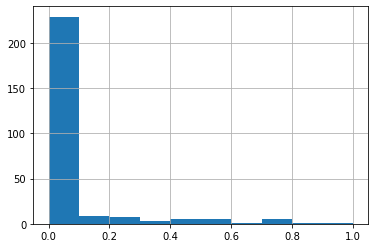

prop_19021 ,non-adjusted


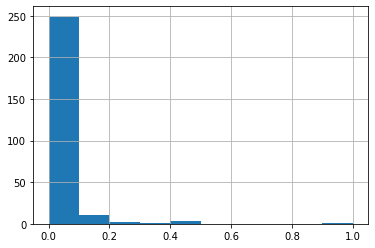

prop_19023 ,non-adjusted


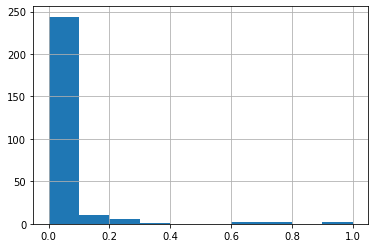

pc_WelIll ,non-adjusted


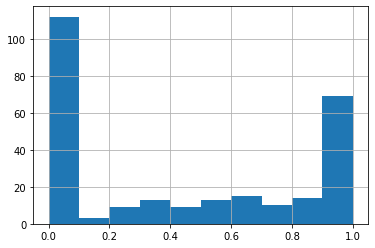

prop_40 ,non-adjusted


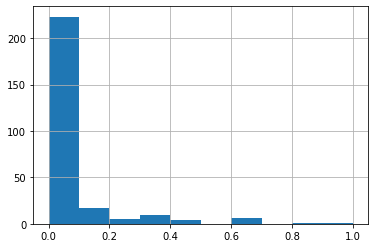

std_tmx16 ,non-adjusted


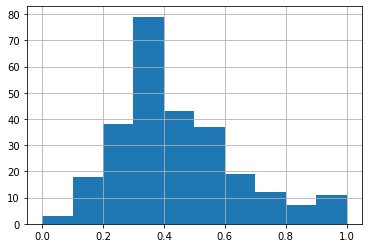

In [12]:
for var in best_features:
    print(var,',non-adjusted')
    dbf_c[var].hist()
    plt.show()

### SPEARMAN CORRELATIONS
Verify consistency of stepwise seletion by analyzing individual Spearman correlation coefficients  
Check all significant correlations (P<0.1)

In [13]:
# Calculate spearman correlations & p-values

# NOTE: Many variables show ZERO-CLUSTERS (many obs. where ind. var. == 0)

# Create dataframe
spear_corr_df = pd.DataFrame()

# Run Spearman correlations for each variable
for var in dbf_c[ind_cols+exclude_lst].columns.difference(['dPrevU5','dPrevU5bis']).to_list():
    spear_r = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[0]
    spear_r_p = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[1]
    obs_var = dbf_c[dbf_c[var]>0].shape[0]
    df = pd.DataFrame([[spear_r, spear_r_p, obs_var]])
    df.index = [var]
    spear_corr_df = spear_corr_df.append(df)
    
# Select significant variables :

# P-value threshold: < 0.1
p_val = 0.1

# List of significant environmental variables, according to criteria above:
spear_corr_df.columns = ["SpCoPrv12","Pval","N_obs>0"]
spear_corr_df_sel_bis = spear_corr_df[(spear_corr_df['Pval']<p_val)]

print("number of sign. variables : ",
      spear_corr_df_sel_bis.shape[0],
      "(out of ",
      spear_corr_df.shape[0],")")

print("p-val. threshold:",p_val)

spear_corr_df_sel_bis

number of sign. variables :  10 (out of  94 )
p-val. threshold: 0.1


,SpCoPrv12,Pval,N_obs>0
edge_11,0.113736,0.063486,32
edge_60,-0.101970,0.096369,7
frac_11,0.113852,0.063217,32
pc_DenPrAr,0.107731,0.078884,44
pc_VPrcAr,0.136667,0.025538,25
prop_11,0.114763,0.061119,32
prop_19042,0.112476,0.066493,20
prop_19043,0.105391,0.085649,44
prop_4342,0.107713,0.078934,44
prop_60,-0.102001,0.096265,7


In [14]:
# Check correlations for variables selected from stepwise selection

spear_corr_stepwise_sel = pd.DataFrame()

for var in best_features:
    spear_r = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[0]
    spear_r_p = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[1]
    obs_var = dbf_c[dbf_c[var]>0].shape[0]
    df = pd.DataFrame([[spear_r, spear_r_p, obs_var]])
    df.index = [var]
    spear_corr_stepwise_sel = spear_corr_stepwise_sel.append(df)
    
spear_corr_stepwise_sel.columns = ["SpCoPrv12","Pval","N_obs>0"]

spear_corr_stepwise_sel

,SpCoPrv12,Pval,N_obs>0
prop_4342,0.107713,0.078934,44
prop_19021,0.067699,0.270335,69
prop_19023,-0.036270,0.555146,65
pc_WelIll,-0.063045,0.304725,157
prop_40,-0.035196,0.566925,138
std_tmx16,0.006312,0.918236,266


### Results of feature selection process

#### >> Selection based both on (1) stepwise regression and (2) Spearman correlation filter

#### >> Selected feature: 'prop_4342'

#### Observations on the selection process:
Most variables selected through the stepwise regression actually show very poor Spearman correlation coefficients (Rho < 0.1 and P values >0.2), and were therefore exluded. Based on the Spearman correlations filter done afterwards, the only retained variable is: 'prop_4342'.  
In the Sperman correlations table, we can identify a global trend, where areas with high-density/low-illumination (classes '19043' & '19042' or 'pc_VPrcAr') are positively correlated to diarrhoea. 

#### Precarious areas (added new composite variable '4342')
Based on the observations above regarding classes '19043' & '19042', a new composite variable was created for dense, precarious built-up areas ('4342'), merging the proportions of the two aforementioned built-up patches. In fact, to avoid multicollinearity, it is certainly more interesting to use ONE variable related to precarious areas, instead of several.  

#### Urban areas
The overall extent and morphology of 'urban' areas (class '190') per se does not seem to affect diarrhoea. However, the quality of urbanization (% of built up areas considered precarious) does. 

# OLS regression with DHS weights & spatial diagnostics

### Check control variables
Exclude control variables that show very poor coefficients in weighted, OLS regression (DHS weights)

In [15]:
# Control variables based on litterature
control_list = ['pc_bas_w','pc_bas_s','pc_imp_h' #control variables related to WASH
                #control variable related to education
                ,'pc_Wnoed'
                #control variables related to climate
                ,'mn_ppt16','mn_tmax16'
               ]
print("control variables:",control_list)

control variables: ['pc_bas_w', 'pc_bas_s', 'pc_imp_h', 'pc_Wnoed', 'mn_ppt16', 'mn_tmax16']


In [16]:
# Weighted Least Squares
Y = dbf_c[dep_var].values
X = dbf_c[control_list].values
print("x_vars:",control_list)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(dbf_c.wt))
results = wls_model.fit()
print(results.summary())

x_vars: ['pc_bas_w', 'pc_bas_s', 'pc_imp_h', 'pc_Wnoed', 'mn_ppt16', 'mn_tmax16']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            WLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.705
Date:                Mon, 23 May 2022   Prob (F-statistic):             0.0145
Time:                        11:19:47   Log-Likelihood:                -16.226
No. Observations:                 267   AIC:                             46.45
Df Residuals:                     260   BIC:                             71.56
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

### Selected control variables
Based on the results above, the following control variables will be discarded, given their very poor P values (P>0.5):  
'pc_imp_h','mn_ppt16','mn_tmax16'

In [17]:
# Selected indep. variable + control variables added to list

# Control variables: based on litterature
control_list = ['pc_bas_w','pc_bas_s'#,'pc_imp_h', #control variables related to WASH
                #control variable related to education
                ,'pc_Wnoed'
                #control variables related to climate
                #,'mn_ppt16'#,'mn_tmax16'
               ]

### Final list of selected features for regression

In [18]:
# Selected independent + control variables
reg_var_list = control_list + ['prop_4342']

print('selected features (control + independent variables):')
print(reg_var_list)

selected features (control + independent variables):
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


#### >> OLS with non-spatial weights (cluster weights given by DHS)

In [19]:
# Weighted Least Squares
Y = dbf_c[dep_var].values
X = dbf_c[reg_var_list].values
print("x_vars:",reg_var_list)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(dbf_c.wt))
results = wls_model.fit()
print(results.summary())

x_vars: ['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            WLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     9.700
Date:                Mon, 23 May 2022   Prob (F-statistic):           2.49e-07
Time:                        11:19:47   Log-Likelihood:                -5.8728
No. Observations:                 267   AIC:                             21.75
Df Residuals:                     262   BIC:                             39.68
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

#### Check for spatial autocorrelation (clusterisation of residuals)
#### >> OLS with spatial diagnostics
references:  
[p.35] http://www.usp.br/nereus/wp-content/uploads/Fischer_Wang_2011_chapter_3.pdf  
https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-35973-1_1294#springerlink-search  
http://darribas.org/gds_scipy16/

In [20]:
# OLS regression with pysal's spreg

# see: https://pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS
# >> include spatial diagnostics for autocorrelation (moran + spat_diag)
# >> these diagnostics indicate whether spatial regression is needed

# set regression inputs
y_var = dbf_c[dep_var].values
x_vars = dbf_c[reg_var_list].values
weight = weights.KNN.from_dataframe(dbf_c,k=16)# k: 16 nearest neighbours

# Run OLS regression with spatial diagnostics 
mols = spreg.OLS(y_var,x_vars,weight,
                 name_x=reg_var_list,
                 moran=True,#compute Moran’s I on the residuals (requires spat_diag=True)
                 spat_diag=True)

# See results
print(mols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         267
Mean dependent var  :      0.3228                Number of Variables   :           5
S.D. dependent var  :      0.2237                Degrees of Freedom    :         262
R-squared           :      0.0631
Adjusted R-squared  :      0.0487
Sum squared residual:      12.466                F-statistic           :      4.4078
Sigma-square        :       0.048                Prob(F-statistic)     :    0.001825
S.E. of regression  :       0.218                Log likelihood        :      30.218
Sigma-square ML     :       0.047                Akaike info criterion :     -50.435
S.E of regression ML:      0.2161                Schwarz criterion     :     -32.499

-----------------------------------------------------------------------------

### >> Spatially weighted regression required
Moran's I of residuals indicates spatial autocorrelation (PROB. < 0.001)  
LM tests: Choose most significant test (value closest to 0)  
If both Lagrange Multiplier tests (for 'error' AND 'lag') are < 0.05, choose the one closest to 0

# Spatial regressions with pysal (spreg)

#### note on bandwidth type:  
in this case, given the large distances between points, adaptive bandwidth (KNN) is best option to avoid 'islands' (obs. without neighbours) in spatial regression.  

#### note on bandwidth value:  
The bandwidth value was set manually, to reasonable number of neighbours: n=8, considering the 8 possible directions (up,down,left,right,etc.)

In [21]:
bandwidth = 8
weight = weights.KNN.from_dataframe(dbf_c,k=bandwidth)
print("weight:",weight)
print("bandwidth:",bandwidth)
print("reg_var_list:")
print(reg_var_list)

weight: <libpysal.weights.distance.KNN object at 0x7fd3e1ba2b50>
bandwidth: 8
reg_var_list:
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


#### Run spatial regressions with LM errors

In [22]:
# set regression inputs
y_var = dbf_c['dPrevU5'].values
x_vars = dbf_c[reg_var_list].values
var_names = ['%basic wat.'
             ,'%basic san.'
             ,'%women no edu.'
             ,'prop. den. pr. areas'
            ]

if len(var_names)==len(reg_var_list):
    print('length of var_names OK!')
else:
    print('ERROR: check length of "var_names"')

length of var_names OK!


In [23]:
# calculate ML Lag
# See: https://spreg.readthedocs.io/en/latest/generated/spreg.ML_Lag.html
# NOTE: method = "ORD" or "LU" works better for large samples
# >> according to https://github.com/pysal/pysal/issues/587
mlag = spreg.ML_Lag(y_var,x_vars,
                    weight,
                    #method = "ORD",
                    name_x=var_names)

print(mlag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         267
Mean dependent var  :      0.3228                Number of Variables   :           6
S.D. dependent var  :      0.2237                Degrees of Freedom    :         261
Pseudo R-squared    :      0.0989
Spatial Pseudo R-squared:  0.0629
Sigma-square ML     :       0.045                Log likelihood        :      34.126
S.E of regression   :       0.212                Akaike info criterion :     -56.252
                                                 Schwarz criterion     :     -34.729

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [24]:
# calculate spatial reg. ML Error
mspe = spreg.ML_Error(y_var,x_vars,
                      weight,
                      #method = "ORD",
                      name_x=var_names)

print(mspe.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         267
Mean dependent var  :      0.3228                Number of Variables   :           5
S.D. dependent var  :      0.2237                Degrees of Freedom    :         262
Pseudo R-squared    :      0.0594
Sigma-square ML     :       0.045                Log likelihood        :      34.113
S.E of regression   :       0.212                Akaike info criterion :     -58.227
                                                 Schwarz criterion     :     -40.290

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------